In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
#!/usr/bin/env python

import numpy as np
import time
import matplotlib.pyplot as plt

import pycuda.autoinit
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
import pycuda.gpuarray as gpuarray

class nlmDenoise:
    def __init__(self):
        # define block and grid dimensions. Block dimension choose after experimentation
        self.getBlockDimension = (16, 16, 4)
        self.getGridDimension = lambda imageWidth, imageHeight, slicesCount, searchWindowRadius: (
        (((imageWidth + 2 * searchWindowRadius) // 16) + 1), (((imageHeight + 2 * searchWindowRadius) // 16) + 1),
        (((slicesCount + 2 * searchWindowRadius) // 4) + 1))

    def gaussianKernel3Dcalculation(self, patchWindowRadius, sigma):
        # Calculate the patch window size from the given patch window radius
        patchWindowSize = 2 * patchWindowRadius + 1
        # Initialize the kernel sum and final kernel array to zeros
        kernelSum = 0
        kernel = np.zeros(patchWindowSize * patchWindowSize * patchWindowSize)
        # Calculate the kernel elements by looping through in all dimensions
        for z in range(-patchWindowRadius, patchWindowRadius + 1):
            for y in range(-patchWindowRadius, patchWindowRadius + 1):
                for x in range(-patchWindowRadius, patchWindowRadius + 1):
                    # Getting the kernel output index
                    kernelIndex = (z + patchWindowRadius) * patchWindowSize * patchWindowSize + (
                            y + patchWindowRadius) * patchWindowSize + (x + patchWindowRadius)
                    # Calculating the kernel value
                    kernel[kernelIndex] = np.exp(-(z * z + y * y + x * x) / (2 * sigma * sigma))
                    # Adding the calculating kernel value to the kernel sum
                    kernelSum += kernel[kernelIndex]
        for index in range(patchWindowSize * patchWindowSize * patchWindowSize):
            # Normalizing the calculated kernel values
            kernel[index] /= kernelSum
        return kernel

    def nlm_denoising_gpu(self, inputDataWithNoise, kernel, imageWidth, imageHeight, slicesCount,
                          searchWindowRadius, patchWindowRadius, stdDev):
        sourceMod = SourceModule("""
#include "stdio.h"
__global__ void nonLocalMeans(const float *inputDataWithNoise,const float *kernel, const int imageWidth,
                                const int imageHeight, const int slicesCount, const int searchWindowRadius,
                                    const int patchWindowRadius, const float stdDev, float *outputDenoisedData)

{
    // Normal indexing scheme in x, y, z since both block and grid dimensions are specified
    int x = threadIdx.x + blockIdx.x * blockDim.x;
    int y = threadIdx.y + blockIdx.y * blockDim.y;
    int	z = threadIdx.z + blockIdx.z * blockDim.z;
    // Threads with image pixels should only be denoising
    if (x >= imageWidth || y >= imageHeight || z >= slicesCount)
        return;
    // Initialize all voxels of the output data to zeros
    outputDenoisedData[z * imageHeight * imageWidth + y * imageWidth + x] = 0;
    // Initialize the sum of weights and max weight to zero
    float sumWeights = 0;
    float maxWeight = 0;

    // Calculate start and end points for search window in all three dimensions
    int startSearchZ = (patchWindowRadius > (z + patchWindowRadius - searchWindowRadius) ? patchWindowRadius :
                                            (z + patchWindowRadius - searchWindowRadius));
    int endSearchZ = ((slicesCount + patchWindowRadius - 1) < (z + patchWindowRadius + searchWindowRadius) ?
                        (slicesCount + patchWindowRadius - 1) : (z + patchWindowRadius + searchWindowRadius));
    int startSearchY = (patchWindowRadius > (y + patchWindowRadius - searchWindowRadius) ?
                                            patchWindowRadius : (y + patchWindowRadius - searchWindowRadius));
    int endSearchY = ((imageHeight + patchWindowRadius - 1) < (y + patchWindowRadius + searchWindowRadius) ?
                        (imageHeight + patchWindowRadius - 1) : (y + patchWindowRadius + searchWindowRadius));
    int startSearchX = (patchWindowRadius > (x + patchWindowRadius - searchWindowRadius) ?
                                            patchWindowRadius : (x + patchWindowRadius - searchWindowRadius));
    int endSearchX = ((imageWidth + patchWindowRadius - 1) < (x + patchWindowRadius + searchWindowRadius) ?
                        (imageWidth + patchWindowRadius - 1) : (x + patchWindowRadius + searchWindowRadius));

    // Run over the search window of the voxel
    for (int searchPosZ = startSearchZ; searchPosZ <= endSearchZ; searchPosZ++)
    {
        for (int searchPosY = startSearchY; searchPosY <= endSearchY; searchPosY++)
        {
            for (int searchPosX = startSearchX; searchPosX <= endSearchX; searchPosX++)
            {
                // If the search window position has reached the boundary in all 3 dimensions then don't consider this window
                if (searchPosX == (x + patchWindowRadius) && searchPosY == (y + patchWindowRadius) && searchPosZ == (z + patchWindowRadius))
                    continue;

                // Initialize the distance and weight metrics to zero
                float distance = 0;
                float weight = 0;

                // Run over the patch window of the voxel
                for (int patchPosZ = -patchWindowRadius; patchPosZ <= patchWindowRadius; patchPosZ++)
                {
                    for (int patchPosY = -patchWindowRadius; patchPosY <= patchWindowRadius; patchPosY++)
                    {
                        for (int patchPosX = -patchWindowRadius; patchPosX <= patchWindowRadius; patchPosX++)
                        {
                            // Get the index for search window
                            int searchPosIndex = (searchPosZ + patchPosZ) * (imageHeight + 2 * patchWindowRadius) * (imageWidth + 2 * patchWindowRadius)
                                                    + (searchPosY + patchPosY) * (imageWidth + 2 * patchWindowRadius) + (searchPosX + patchPosX);
                            // Get the index for kernel
                            int kernelPosIndex = (patchPosZ + patchWindowRadius) * (2 * patchWindowRadius + 1) * (2 * patchWindowRadius + 1) +
                                                    (patchPosY + patchWindowRadius) * (2 * patchWindowRadius + 1) + (patchPosX + patchWindowRadius);
                            // Get the index for the voxel
                            int voxelPosIndex = (z + patchWindowRadius + patchPosZ) * (imageHeight + 2 * patchWindowRadius) * (imageWidth + 2 * patchWindowRadius) +
                                                    (y + patchWindowRadius + patchPosY) * (imageWidth + 2 * patchWindowRadius) + (x + patchWindowRadius + patchPosX);
                            // Compute the gaussian kernel weighted euclidean distance
                            distance += kernel[kernelPosIndex] * (inputDataWithNoise[searchPosIndex] - inputDataWithNoise[voxelPosIndex]) *
                                        (inputDataWithNoise[searchPosIndex] - inputDataWithNoise[voxelPosIndex]);
                        }
                    }
                }
                // Compute the weight for search window voxel
                weight = expf(-distance / (stdDev * stdDev));
                // Adding up weights for all voxels in search window
                sumWeights += weight;
                // Getting the maximum weight within the search window
                maxWeight = (weight > maxWeight) ? weight : maxWeight;
                // Writing to the output voxel
                outputDenoisedData[z * imageHeight * imageWidth + y * imageWidth + x] += weight * inputDataWithNoise[searchPosZ * (imageHeight + 2 * patchWindowRadius) *
                                                                                            (imageWidth + 2 * patchWindowRadius) + searchPosY *
                                                                                                (imageWidth + 2 * patchWindowRadius) + searchPosX];
            }
        }
    }
    // Writing to the output voxel
    outputDenoisedData[z * imageHeight * imageWidth + y * imageWidth + x] += maxWeight * inputDataWithNoise[(z + patchWindowRadius) * (imageHeight + 2 * patchWindowRadius) *
                                                                                (imageWidth + 2 * patchWindowRadius) + (y + patchWindowRadius) *
                                                                                    (imageWidth + 2 * patchWindowRadius) + (x + patchWindowRadius)];
    // Normalizing the denoised output
    outputDenoisedData[z * imageHeight * imageWidth + y * imageWidth + x] /= (sumWeights + maxWeight);
}
""")
        nlmKernel = sourceMod.get_function("nonLocalMeans")
        # Event objects to mark the start and end points
        start = cuda.Event()
        end = cuda.Event()
        # Recording execution time including memory transfer.
        start.record()
        # Copy the input noisy data to the device
        inputDataWithNoise_gpu = gpuarray.to_gpu(inputDataWithNoise)
        # Initialize the output denoised data in the device
        outputDenoisedData_gpu = gpuarray.zeros(imageWidth * imageHeight * slicesCount, dtype = np.float32)
        kernel = kernel.astype(np.float32)
        kernel_gpu = gpuarray.to_gpu(kernel)
        # Execute the non local means parallel algorithm with constant memory implementation
        nlmKernel(inputDataWithNoise_gpu, kernel_gpu, np.int32(imageWidth), np.int32(imageHeight),
                  np.int32(slicesCount), np.int32(searchWindowRadius), np.int32(patchWindowRadius), np.float32(stdDev),
                  outputDenoisedData_gpu, block=self.getBlockDimension, grid = self.getGridDimension(imageWidth, imageHeight,
                                                                                         slicesCount, patchWindowRadius))
        outputDenoisedData = outputDenoisedData_gpu.get()
        # Wait for the event to complete and synchronize
        end.record()
        end.synchronize()
        # Record execution time
        time_ = start.time_till(end)
        return outputDenoisedData, time_

    def nlm_denoising_const_mem_gpu(self, inputDataWithNoise, kernel, imageWidth, imageHeight, slicesCount,
                          searchWindowRadius, patchWindowRadius, stdDev):
        sourceMod = SourceModule("""
        // Define the patch window size here (2 * patchWindowRadius - 1)
#define patchWindowSize 5
// Constant memory cannot be dynamically allocated like shared memory using extern
__device__ __constant__ float kernel[patchWindowSize * patchWindowSize * patchWindowSize];
#include "stdio.h"
__global__ void nonLocalMeansConstMem(const float *inputDataWithNoise, const int imageWidth, const int imageHeight,
                                        const int slicesCount, const int searchWindowRadius,
                                            const int patchWindowRadius, const float stdDev, float *outputDenoisedData)

{
    // Normal indexing scheme in x, y, z since both block and grid dimensions are specified
    int x = threadIdx.x + blockIdx.x * blockDim.x;
    int y = threadIdx.y + blockIdx.y * blockDim.y;
    int	z = threadIdx.z + blockIdx.z * blockDim.z;
    // Threads with image pixels should only be denoising
    if (x >= imageWidth || y >= imageHeight || z >= slicesCount)
        return;
    // Initialize all voxels of the output data to zeros
    outputDenoisedData[z * imageHeight * imageWidth + y * imageWidth + x] = 0;
    // Initialize the sum of weights and max weight to zero
    float sumWeights = 0;
    float maxWeight = 0;

    // Calculate start and end points for search window in all three dimensions
    int startSearchZ = (patchWindowRadius > (z + patchWindowRadius - searchWindowRadius) ? patchWindowRadius :
                                            (z + patchWindowRadius - searchWindowRadius));
    int endSearchZ = ((slicesCount + patchWindowRadius - 1) < (z + patchWindowRadius + searchWindowRadius) ?
                        (slicesCount + patchWindowRadius - 1) : (z + patchWindowRadius + searchWindowRadius));
    int startSearchY = (patchWindowRadius > (y + patchWindowRadius - searchWindowRadius) ?
                                            patchWindowRadius : (y + patchWindowRadius - searchWindowRadius));
    int endSearchY = ((imageHeight + patchWindowRadius - 1) < (y + patchWindowRadius + searchWindowRadius) ?
                        (imageHeight + patchWindowRadius - 1) : (y + patchWindowRadius + searchWindowRadius));
    int startSearchX = (patchWindowRadius > (x + patchWindowRadius - searchWindowRadius) ?
                                            patchWindowRadius : (x + patchWindowRadius - searchWindowRadius));
    int endSearchX = ((imageWidth + patchWindowRadius - 1) < (x + patchWindowRadius + searchWindowRadius) ?
                        (imageWidth + patchWindowRadius - 1) : (x + patchWindowRadius + searchWindowRadius));

    // Run over the search window of the voxel
    for (int searchPosZ = startSearchZ; searchPosZ <= endSearchZ; searchPosZ++)
    {
        for (int searchPosY = startSearchY; searchPosY <= endSearchY; searchPosY++)
        {
            for (int searchPosX = startSearchX; searchPosX <= endSearchX; searchPosX++)
            {
                // If the search window position has reached the boundary in all 3 dimensions then don't consider this window
                if (searchPosX == (x + patchWindowRadius) && searchPosY == (y + patchWindowRadius) && searchPosZ == (z + patchWindowRadius))
                    continue;

                // Initialize the distance and weight metrics to zero
                float distance = 0;
                float weight = 0;

                // Run over the patch window of the voxel
                for (int patchPosZ = -patchWindowRadius; patchPosZ <= patchWindowRadius; patchPosZ++)
                {
                    for (int patchPosY = -patchWindowRadius; patchPosY <= patchWindowRadius; patchPosY++)
                    {
                        for (int patchPosX = -patchWindowRadius; patchPosX <= patchWindowRadius; patchPosX++)
                        {
                            // Get the index for search window
                            int searchPosIndex = (searchPosZ + patchPosZ) * (imageHeight + 2 * patchWindowRadius) * (imageWidth + 2 * patchWindowRadius)
                                                    + (searchPosY + patchPosY) * (imageWidth + 2 * patchWindowRadius) + (searchPosX + patchPosX);
                            // Get the index for kernel
                            int kernelPosIndex = (patchPosZ + patchWindowRadius) * (2 * patchWindowRadius + 1) * (2 * patchWindowRadius + 1) +
                                                    (patchPosY + patchWindowRadius) * (2 * patchWindowRadius + 1) + (patchPosX + patchWindowRadius);
                            // Get the index for the voxel
                            int voxelPosIndex = (z + patchWindowRadius + patchPosZ) * (imageHeight + 2 * patchWindowRadius) * (imageWidth + 2 * patchWindowRadius) +
                                                    (y + patchWindowRadius + patchPosY) * (imageWidth + 2 * patchWindowRadius) + (x + patchWindowRadius + patchPosX);
                            // Compute the gaussian kernel weighted euclidean distance
                            distance += kernel[kernelPosIndex] * (inputDataWithNoise[searchPosIndex] - inputDataWithNoise[voxelPosIndex]) *
                                        (inputDataWithNoise[searchPosIndex] - inputDataWithNoise[voxelPosIndex]);
                        }
                    }
                }
                // Compute the weight for search window voxel
                weight = expf(-distance / (stdDev * stdDev));
                // Adding up weights for all voxels in search window
                sumWeights += weight;
                // Getting the maximum weight within the search window
                maxWeight = (weight > maxWeight) ? weight : maxWeight;
                // Writing to the output voxel
                outputDenoisedData[z * imageHeight * imageWidth + y * imageWidth + x] += weight * inputDataWithNoise[searchPosZ * (imageHeight + 2 * patchWindowRadius) *
                                                                                            (imageWidth + 2 * patchWindowRadius) + searchPosY *
                                                                                                (imageWidth + 2 * patchWindowRadius) + searchPosX];
            }
        }
    }
    // Writing to the output voxel
    outputDenoisedData[z * imageHeight * imageWidth + y * imageWidth + x] += maxWeight * inputDataWithNoise[(z + patchWindowRadius) * (imageHeight + 2 * patchWindowRadius) *
                                                                                (imageWidth + 2 * patchWindowRadius) + (y + patchWindowRadius) *
                                                                                    (imageWidth + 2 * patchWindowRadius) + (x + patchWindowRadius)];
    // Normalizing the denoised output
    outputDenoisedData[z * imageHeight * imageWidth + y * imageWidth + x] /= (sumWeights + maxWeight);
}
""")
        nlmConstMemKernel = sourceMod.get_function("nonLocalMeansConstMem")
        # Event objects to mark the start and end points
        start = cuda.Event()
        end = cuda.Event()
        # Recording execution time including memory transfer.
        start.record()
        # Copy the input noisy data to the device
        inputDataWithNoise_gpu = gpuarray.to_gpu(inputDataWithNoise)
        # Initialize the output denoised data in the device
        outputDenoisedData_gpu = gpuarray.zeros(imageWidth * imageHeight * slicesCount, dtype = np.float32)
        kernel = kernel.astype(np.float32)
        # Get the constant memory address for the kernel
        kernel_addr = sourceMod.get_global('kernel')[0]
        # Copy the kernel to the constant memory
        cuda.memcpy_htod(kernel_addr, kernel)
        # Execute the non local means parallel algorithm with constant memory implementation
        nlmConstMemKernel(inputDataWithNoise_gpu, np.int32(imageWidth), np.int32(imageHeight),
                  np.int32(slicesCount), np.int32(searchWindowRadius), np.int32(patchWindowRadius), np.float32(stdDev),
                  outputDenoisedData_gpu, block=self.getBlockDimension, grid = self.getGridDimension(imageWidth, imageHeight,
                                                                                         slicesCount, patchWindowRadius))
        outputDenoisedData = outputDenoisedData_gpu.get()
        # Wait for the event to complete and synchronize
        end.record()
        end.synchronize()
        # Record execution time
        time_ = start.time_till(end)
        return outputDenoisedData, time_

if __name__ == "__main__":
    # Create an instance of the nlmDenoise class
    nlm = nlmDenoise()
    # Patch Window size taken as 5X5X5
    patchWindowRadius = 2
    # Search Window size taken as 11X11X11
    searchWindowRadius = 5
    # Dimensions of the test image
    imageWidth = 181
    imageHeight = 217
    slicesCount = 10
    # Default values of sigma and standard values defined
    sigma = 1
    stdDev = 10.0
    # Computing the gaussian filter kernel
    kernel = nlm.gaussianKernel3Dcalculation(patchWindowRadius, sigma)
    # Reading input binary data as a float 32 array
    inputDataWithNoise = np.fromfile("imageNoisyPaddedInput5X5X5Slices10.bin", dtype = np.float32, sep = '')
    outputDenoisedData, time = nlm.nlm_denoising_gpu(inputDataWithNoise, kernel, imageWidth, imageHeight, slicesCount,
                          searchWindowRadius, patchWindowRadius, stdDev)
    print("Time taken to denoise by gpu is ", time)
    # Write the gpu denoised output float 32 array to a binary file
    outputDenoisedData.astype('float32').tofile('gpu_output.bin', sep = '')
    outputDenoisedDataConstMem, time = nlm.nlm_denoising_const_mem_gpu(inputDataWithNoise, kernel, imageWidth, imageHeight,
                                                               slicesCount, searchWindowRadius, patchWindowRadius, stdDev)
    print("Time taken to denoise by gpu using constant memory for kernel is ", time)
    # Write the gpu denoised output float 32 array to a binary file
    outputDenoisedDataConstMem.astype('float32').tofile('gpu_const_mem_output.bin', sep = '')

Time taken to denoise by gpu is  2640.519287109375
Time taken to denoise by gpu using constant memory for kernel is  2004.6240234375


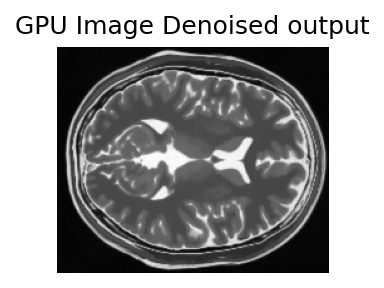

In [3]:
# Parallel implementation denoised image
# Reshaping the numpy float 1D array to 3D images dimensions
denoise = outputDenoisedData.reshape(slicesCount, imageHeight, imageWidth).T
fig = plt.figure(figsize = (3, 2), dpi = 150)
plt.axis('off')
plt.title('GPU Image Denoised output')
plt.imshow(denoise[:, :, 1], cmap='gray')
plt.savefig('gpuImageDenoised.png')

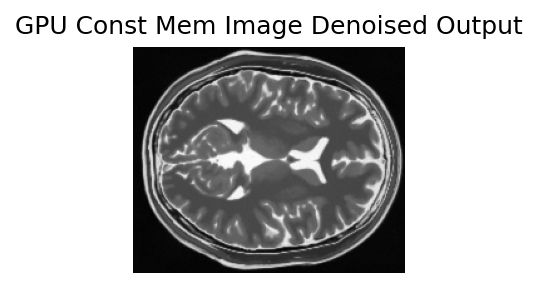

In [4]:
# Parallel with constant memeory implementation denoised image
# Reshaping the numpy float 1D array to 3D images dimensions
denoise = outputDenoisedDataConstMem.reshape(slicesCount, imageHeight, imageWidth).T
fig = plt.figure(figsize = (3, 2), dpi = 150)
plt.axis('off')
plt.title('GPU Const Mem Image Denoised Output')
plt.imshow(denoise[:, :, 1], cmap='gray')
plt.savefig('gpuConstMemImageDenoised.png')